<a href="https://colab.research.google.com/github/harinig07/Content-Based-Image-Retrieval/blob/main/Wang_image_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os
import zipfile
import random
import pickle
import ast
import time
from pathlib import Path
from scipy.spatial import distance
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''
#execute only for first time

zip_path = '/content/test1.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/cv_project1/Dataset/') 
'''

In [ ]:
test_sample_index=[]
for i in range(10):
  start=i*100
  end=(i+1)*100-1
  list1=list(range(start,end+1))
  random.seed(42)
  indices=random.sample(list1,25)
  test_sample_index+=indices



In [ ]:
test_sample_index

In [ ]:
train_path='/content/drive/MyDrive/cv_project1/Dataset/image.orig'

Image Dictionary

In [ ]:
def extract_features(img):
  img_to_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  sift=cv2.xfeatures2d.SIFT_create(contrastThreshold=0.0)
  kp1, des1 = sift.detectAndCompute(img_to_gray, None)
  return des1

In [ ]:
#change normed =true into density =true  tosuppress warning
def baseline_hist(img):
    r_hist, r_bins = np.histogram(img[:,:,0], 64, normed=True)
    g_hist, g_bins = np.histogram(img[:,:,1], 64, normed=True)
    b_hist, b_bins = np.histogram(img[:,:,2], 64, normed=True)
    featvect = np.concatenate((r_hist, g_hist, b_hist))

In [ ]:
def find_distance(feature_vectors):
    D = distance.squareform(distance.pdist(feature_vectors, 'cosine') )
    return D

In [ ]:
count=0
features=[]
train_index=[]
baseline_features=[]
for imgs in os.listdir(train_path):
 img_path=os.path.join(train_path,imgs)
 temp=Path(img_path).stem
 temp = int(temp)
 if temp not in test_sample_index:
  count+=1
  train_index.append(temp)
  img=cv2.imread(os.path.join(img_path))
  features.append(extract_features(img))
 

features1=np.vstack(features)
  

In [ ]:
features1.shape

(1038032, 128)

In [ ]:
#Run only when the dictionary of the model need to be changed
'''
train_img_names_path = '/content/drive/MyDrive/cv_project1/model/'
with open(train_img_names_path+"train_indices_wang.txt",'w') as f:
  f.write(str(train_index))'''

In [ ]:
def kmean_cluster(stacked_features,n_clusters,model_name):
  start=time.time()
  model,y=kmeans(np.float32(stacked_features),n_clusters)

  #saving the model
  model_path = '/content/drive/MyDrive/cv_project1/model/'
  with open(model_path + model_name, "wb") as f:
    pickle.dump(model, f)
  end=time.time()
  print('Time take to cluster{}'.format(start-end))
  return model


In [ ]:
def create_bow(features_set,model,n_clusters,bow_model_name):
  bow=[]
  for f in features:
    f=np.vstack(f)
    code,distortion=vq(f,model)
    bow1_hist,_=np.histogram(code,n_clusters)
    bow.append(bow1_hist)

  temparr = np.vstack(bow)
  fv = np.reshape(temparr, (temparr.shape[0], temparr.shape[1]))
  
  #Saving the bow for image representation
  model_path = '/content/drive/MyDrive/cv_project1/model/'
  with open(model_path + bow_model_name, "wb") as f:
    pickle.dump(fv, f)
  return bow

In [ ]:
def create_tf_idf(bow,tf_idf_model_name):
  transformer =  TfidfTransformer(smooth_idf=True)
  t = transformer.fit_transform(bow).toarray()
  t = normalize(t, norm='l2', axis=1)
  model_path = '/content/drive/MyDrive/cv_project1/model/'
  with open(model_path + tf_idf_model_name, "wb") as f:
    pickle.dump(t, f)


In [ ]:
#Run this cell by uncommenting only if the changes is required in image dictionary
'''
#model with 25 visual words
model_name="model_25_wang.pkl"
model_25=kmean_cluster(features1,25,model_name)
bow_name="model_bow_25_wang.pkl"
bow_25=create_bow(features,model_25,25,bow_model_name)
bow_25=np.vstack(bow_25)
tfidf_model_name="tfidf_model_25_wang.pkl"
create_tf_idf(bow_25,tfidf_model_name)

#model with 30 visual words
model_name="model_30_wang.pkl"
model_30=kmean_cluster(features1,30,model_name)
bow_name="model_bow_30.pkl"
bow_30=create_bow(features,model_30,30,bow_model_name)
bow_30=np.vstack(bow_30)
tfidf_model_name="tfidf_model_30_wang.pkl"
create_tf_idf(bow_30,tfidf_model_name)

#model with 50 visual words
model_name="model_50_wang.pkl"
model_50=kmean_cluster(features1,50,model_name)
bow_name="model_bow_50.pkl"
bow_50=create_bow(features,model_50,50,bow_model_name)
bow_50=np.vstack(bow_50)
tfidf_model_name="tfidf_model_50_wang.pkl"
create_tf_idf(bow_50,tfidf_model_name)

'''

Query evaluation

In [168]:
def find_match_imgs_and_evaluate(test_img,model,n_clusters,model_op,n_retrieved,train_index):
  test_image_features=extract_features(test_img)
  test_image_features=np.vstack(test_image_features)
  test_image_features.shape

  code_test,distortion_test=vq(test_image_features,model)
  bow_test_hist,_=np.histogram(code_test,model.shape[0])

 
  feat_vect=model_op
  feat_vect=np.insert(feat_vect,0,bow_test_hist,axis=0)
  
  D=find_distance(feat_vect)
  nearest_idx = np.argsort(D[0, :])
  


  retrieved_indices=[]
  for i in range(1,n_retrieved+1):
      train_img_name=train_index[nearest_idx[i]]
      retrieved_indices.append(train_img_name)
      train_img_path=train_path+"/"+str(train_img_name)+extension
      img_retrieved=cv2.imread(train_img_path)
      plt.imshow(img_retrieved)
      plt.show()
  
  #to see histogram of each images

  for i in range(1,n_retrieved+1):
    train_img_name=train_index[nearest_idx[i]]
    train_img_path=train_path+"/"+str(train_img_name)+extension
    img_retrieved=cv2.imread(train_img_path)
    retrieved_image_features=extract_features(img_retrieved)
    retrieved_image_features=np.vstack(retrieved_image_features)
    code_img,distortion_img=vq(retrieved_image_features,model)
    plt.hist(code_img,bins=25,edgecolor='black')
    plt.show()
  

 
  for i in range(0,10):
    lower_bound=i*100
    upper_bound=(i+1)*100
    if lower_bound<=test_img_index<upper_bound:
      #TP=len([x for x in retrieved_indices if lower_bound<=x<upper_bound])
      count_tp=0
      count=0
      precision=[]
      recall=[]
      for x in retrieved_indices:
        print(x)
        if lower_bound<=x<upper_bound:
          count_tp+=1
          count+=1
          temp_precision=count_tp/count
          temp_recall=count_tp/75
          precision.append(temp_precision)
          recall.append(temp_recall)
        else:
          count+=1
          temp_precision=count_tp/count
          temp_recall=count_tp/75
          precision.append(temp_precision)
          recall.append(temp_recall)
      break
  return precision,recall

Query evaluation

In [ ]:
train_img_names_path = '/content/drive/MyDrive/cv_project1/model/'
with open(train_img_names_path+'train_indices_wang.txt','r') as f:
 num_list=f.read()
train_index = ast.literal_eval(num_list)
print(train_index)

[0, 1, 10, 100, 101, 102, 105, 106, 107, 108, 109, 110, 112, 115, 116, 118, 119, 12, 120, 121, 122, 123, 124, 126, 130, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 15, 150, 151, 152, 153, 155, 156, 157, 158, 159, 16, 160, 161, 162, 163, 165, 166, 167, 168, 170, 172, 173, 174, 176, 178, 179, 18, 180, 182, 183, 185, 187, 19, 190, 191, 192, 193, 195, 196, 198, 199, 2, 20, 200, 201, 202, 205, 206, 207, 208, 209, 21, 210, 212, 215, 216, 218, 219, 22, 220, 221, 222, 223, 224, 226, 23, 230, 232, 233, 234, 236, 237, 238, 239, 24, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 255, 256, 257, 258, 259, 26, 260, 261, 262, 263, 265, 266, 267, 268, 270, 272, 273, 274, 276, 278, 279, 280, 282, 283, 285, 287, 290, 291, 292, 293, 295, 296, 298, 299, 30, 300, 301, 302, 305, 306, 307, 308, 309, 310, 312, 315, 316, 318, 319, 32, 320, 321, 322, 323, 324, 326, 33, 330, 332, 333, 334, 336, 337, 338, 339, 34, 340, 341, 342, 343, 344, 345, 346, 3

In [169]:
model_path='/content/drive/MyDrive/cv_project1/model/model_25_wang.pkl'
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [170]:
model_path='/content/drive/MyDrive/cv_project1/model/model_bow_25_wang.pkl'
with open(model_path, "rb") as f:
    model_bow = pickle.load(f)

In [ ]:
test_img_index = random.choice(test_sample_index)
test_img_index

197

In [171]:
test_img_index=410

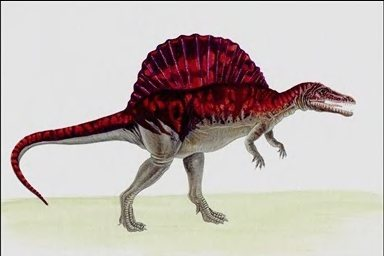

In [172]:
extension=".jpg"
test_img_path = train_path + "/" + str(test_img_index) + extension
test_img=cv2.imread(test_img_path)
cv2_imshow(test_img)

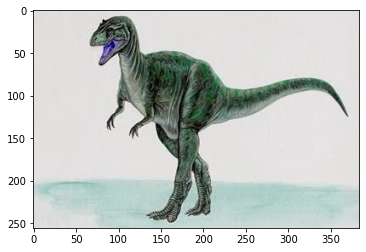

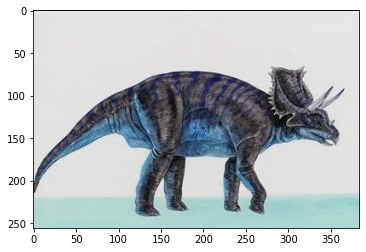

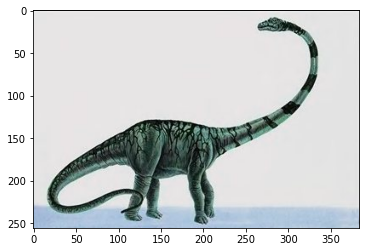

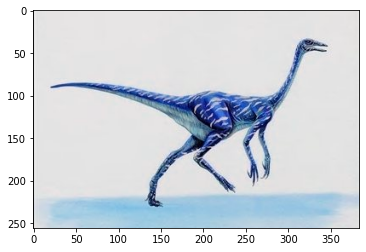

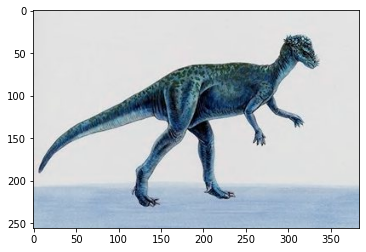

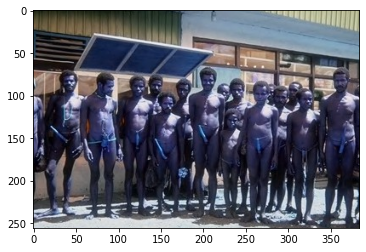

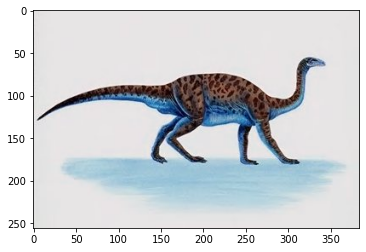

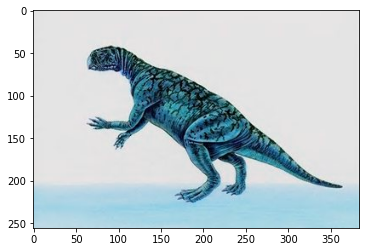

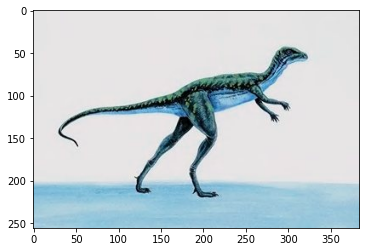

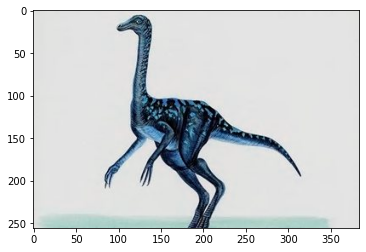

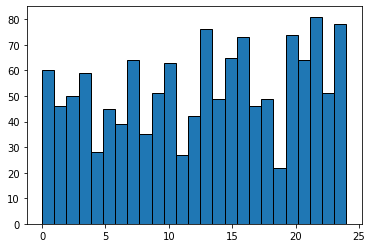

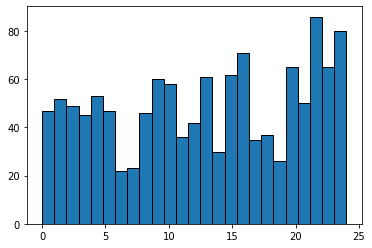

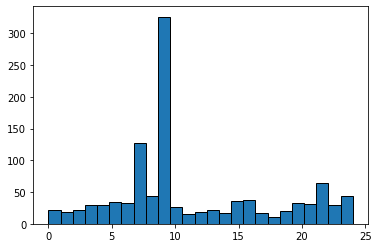

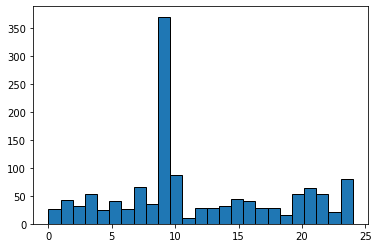

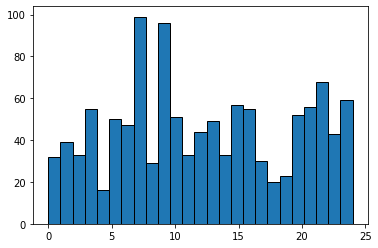

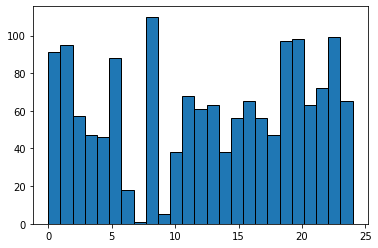

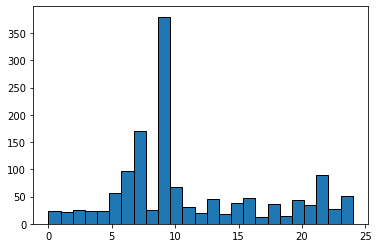

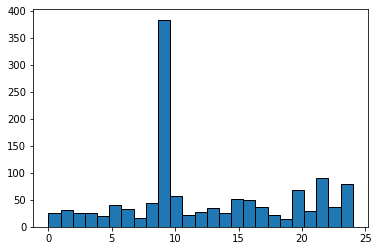

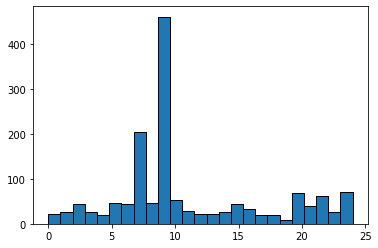

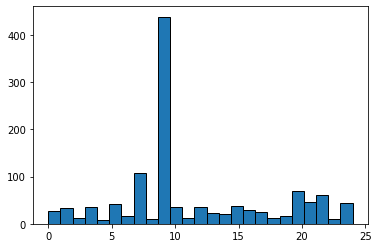

412
422
409
407
482
49
472
406
463
456


In [173]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,25,model_bow,10,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9]
[0.013333333333333334, 0.02666666666666667, 0.04, 0.05333333333333334, 0.06666666666666667, 0.06666666666666667, 0.08, 0.09333333333333334, 0.10666666666666667, 0.12]
Mean of precision is 0.9354365079365079
Mean of recall is 0.06666666666666667


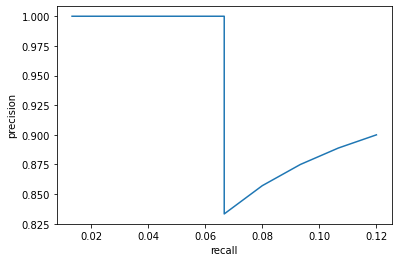

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,25,model_bow,20,train_index)

412
422
409
407
482
49
472
406
463
456
418
42
408
448
498
453
476
402
5
458


[1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9, 0.9090909090909091, 0.8333333333333334, 0.8461538461538461, 0.8571428571428571, 0.8666666666666667, 0.875, 0.8823529411764706, 0.8888888888888888, 0.8421052631578947, 0.85]
[0.013333333333333334, 0.02666666666666667, 0.04, 0.05333333333333334, 0.06666666666666667, 0.06666666666666667, 0.08, 0.09333333333333334, 0.10666666666666667, 0.12, 0.13333333333333333, 0.13333333333333333, 0.14666666666666667, 0.16, 0.17333333333333334, 0.18666666666666668, 0.2, 0.21333333333333335, 0.21333333333333335, 0.22666666666666666]
Mean of precision is 0.9002549892487973
Mean of recall is 0.12266666666666666


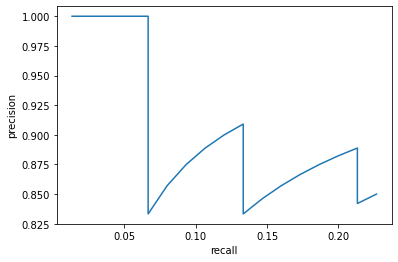

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
model_bow=np.vstack(model_bow)
tfidf_model_name="tfidf_model_25_wang.pkl"
create_tf_idf(model_bow,tfidf_model_name)

In [ ]:
model_path='/content/drive/MyDrive/cv_project1/model/tfidf_model_25_wang.pkl'
with open(model_path, "rb") as f:
    model_tfidf = pickle.load(f)

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,25,model_tfidf,10,train_index)

412
422
482
409
463
418
407
406
456
49


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9]
[0.013333333333333334, 0.02666666666666667, 0.04, 0.05333333333333334, 0.06666666666666667, 0.08, 0.09333333333333334, 0.10666666666666667, 0.12, 0.12]
Mean of precision is 0.99
Mean of recall is 0.072


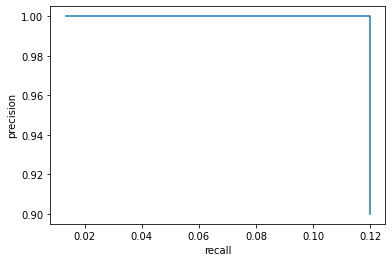

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,25,model_tfidf,20,train_index)

412
422
482
409
463
418
407
406
456
49
472
498
408
432
451
476
42
453
448
405


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9090909090909091, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.8823529411764706, 0.8888888888888888, 0.8947368421052632, 0.9]
[0.013333333333333334, 0.02666666666666667, 0.04, 0.05333333333333334, 0.06666666666666667, 0.08, 0.09333333333333334, 0.10666666666666667, 0.12, 0.12, 0.13333333333333333, 0.14666666666666667, 0.16, 0.17333333333333334, 0.18666666666666668, 0.2, 0.2, 0.21333333333333335, 0.22666666666666666, 0.24]
Mean of precision is 0.9507108966454941
Mean of recall is 0.12999999999999998


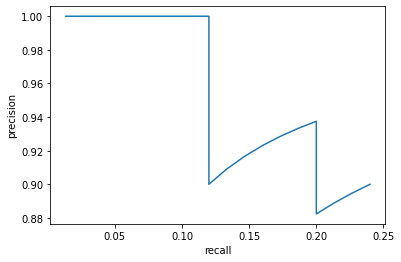

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

Model with n_clusters=30

In [ ]:
model_path='/content/drive/MyDrive/cv_project1/model/model_30_wang.pkl'
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [ ]:
bow_name="model_bow_30_wang.pkl"
bow_model=create_bow(features,model,30,bow_name)

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,30,bow_model,10,train_index)

412
422
407
409
482
49
456
472
406
463


[1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9]
[0.013333333333333334, 0.02666666666666667, 0.04, 0.05333333333333334, 0.06666666666666667, 0.06666666666666667, 0.08, 0.09333333333333334, 0.10666666666666667, 0.12]
Mean of precision is 0.9354365079365079
Mean of recall is 0.06666666666666667


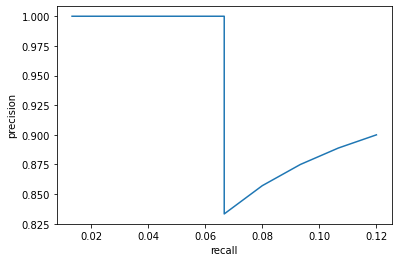

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,30,bow_model,20,train_index)

412
422
407
409
482
49
456
472
406
463
448
42
408
418
453
498
476
402
5
447


[1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9, 0.9090909090909091, 0.8333333333333334, 0.8461538461538461, 0.8571428571428571, 0.8666666666666667, 0.875, 0.8823529411764706, 0.8888888888888888, 0.8421052631578947, 0.85]
[0.013333333333333334, 0.02666666666666667, 0.04, 0.05333333333333334, 0.06666666666666667, 0.06666666666666667, 0.08, 0.09333333333333334, 0.10666666666666667, 0.12, 0.13333333333333333, 0.13333333333333333, 0.14666666666666667, 0.16, 0.17333333333333334, 0.18666666666666668, 0.2, 0.21333333333333335, 0.21333333333333335, 0.22666666666666666]
Mean of precision is 0.9002549892487973
Mean of recall is 0.12266666666666666


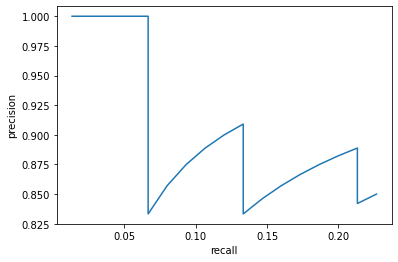

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
model_bow=np.vstack(bow_model)
tfidf_model_name="tfidf_model_30_wang.pkl"
create_tf_idf(model_bow,tfidf_model_name)

In [ ]:
model_path='/content/drive/MyDrive/cv_project1/model/tfidf_model_30_wang.pkl'
with open(model_path, "rb") as f:
    model_tfidf = pickle.load(f)

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,30,model_tfidf,10,train_index)

412
422
482
409
407
463
456
406
49
418


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8888888888888888, 0.9]
[0.013333333333333334, 0.02666666666666667, 0.04, 0.05333333333333334, 0.06666666666666667, 0.08, 0.09333333333333334, 0.10666666666666667, 0.10666666666666667, 0.12]
Mean of precision is 0.9788888888888889
Mean of recall is 0.07066666666666667


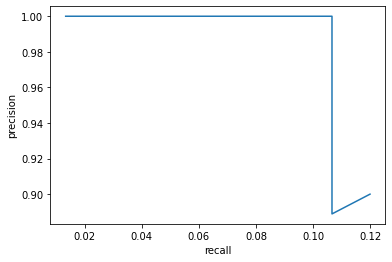

In [ ]:
print(precision)
print(recall)
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()


In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,30,model_tfidf,20,train_index)

412
422
482
409
407
463
456
406
49
418
472
408
498
448
476
453
432
42
405
451


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8888888888888888, 0.9, 0.9090909090909091, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.9411764705882353, 0.8888888888888888, 0.8947368421052632, 0.9]
[0.013333333333333334, 0.02666666666666667, 0.04, 0.05333333333333334, 0.06666666666666667, 0.08, 0.09333333333333334, 0.10666666666666667, 0.10666666666666667, 0.12, 0.13333333333333333, 0.14666666666666667, 0.16, 0.17333333333333334, 0.18666666666666668, 0.2, 0.21333333333333335, 0.21333333333333335, 0.22666666666666666, 0.24]
Mean of precision is 0.9480965175605268
Mean of recall is 0.12999999999999998


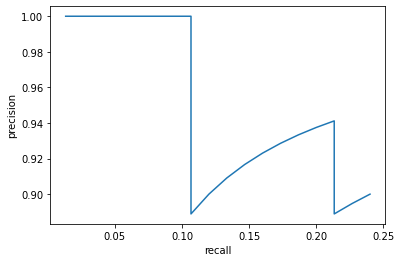

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

Model with n_clusters=50

In [ ]:
model_path='/content/drive/MyDrive/cv_project1/model/model_50_wang.pkl'
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [ ]:
bow_name="model_bow_50.pkl"
bow_model=create_bow(features,model,50,bow_name)

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,50,bow_model,10,train_index)

412
422
407
409
482
408
42
448
463
406


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9]
[0.013333333333333334, 0.02666666666666667, 0.04, 0.05333333333333334, 0.06666666666666667, 0.08, 0.08, 0.09333333333333334, 0.10666666666666667, 0.12]
Mean of precision is 0.9521031746031747
Mean of recall is 0.068


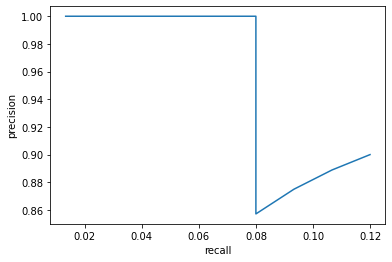

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,50,bow_model,20,train_index)

412
422
407
409
482
408
42
448
463
406
456
49
472
5
453
418
449
402
498
451


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9, 0.9090909090909091, 0.8333333333333334, 0.8461538461538461, 0.7857142857142857, 0.8, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.8421052631578947, 0.85]
[0.013333333333333334, 0.02666666666666667, 0.04, 0.05333333333333334, 0.06666666666666667, 0.08, 0.08, 0.09333333333333334, 0.10666666666666667, 0.12, 0.13333333333333333, 0.13333333333333333, 0.14666666666666667, 0.14666666666666667, 0.16, 0.17333333333333334, 0.18666666666666668, 0.2, 0.21333333333333335, 0.22666666666666666]
Mean of precision is 0.8928396064290027
Mean of recall is 0.12


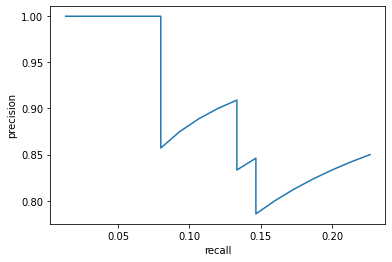

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
model_bow=np.vstack(bow_model)
tfidf_model_name="tfidf_model_50_wang.pkl"
create_tf_idf(model_bow,tfidf_model_name)

In [ ]:
model_path='/content/drive/MyDrive/cv_project1/model/tfidf_model_50_wang.pkl'
with open(model_path, "rb") as f:
    model_tfidf = pickle.load(f)

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,50,model_tfidf,10,train_index)

412
422
407
409
463
408
42
448
456
482


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9]
[0.013333333333333334, 0.02666666666666667, 0.04, 0.05333333333333334, 0.06666666666666667, 0.08, 0.08, 0.09333333333333334, 0.10666666666666667, 0.12]
Mean of precision is 0.9521031746031747
Mean of recall is 0.068


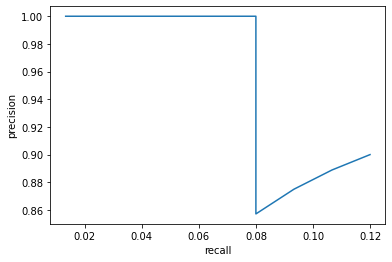

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,50,model_tfidf,20,train_index)

412
422
407
409
463
408
42
448
456
482
49
472
453
449
406
5
438
498
476
402


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 0.875, 0.8888888888888888, 0.9, 0.8181818181818182, 0.8333333333333334, 0.8461538461538461, 0.8571428571428571, 0.8666666666666667, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.8421052631578947, 0.85]
[0.013333333333333334, 0.02666666666666667, 0.04, 0.05333333333333334, 0.06666666666666667, 0.08, 0.08, 0.09333333333333334, 0.10666666666666667, 0.12, 0.12, 0.13333333333333333, 0.14666666666666667, 0.16, 0.17333333333333334, 0.17333333333333334, 0.18666666666666668, 0.2, 0.21333333333333335, 0.22666666666666666]
Mean of precision is 0.8951989137883102
Mean of recall is 0.12066666666666666


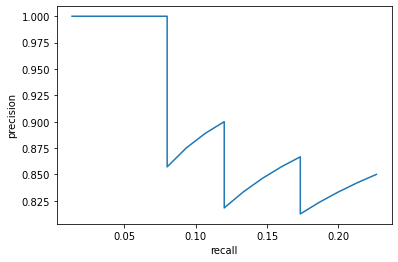

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))

Model 25 better model

In [ ]:
model_path='/content/drive/MyDrive/cv_project1/model/model_25_wang.pkl'
with open(model_path, "rb") as f:
    model = pickle.load(f)

In [ ]:
model_path='/content/drive/MyDrive/cv_project1/model/model_bow_25_wang.pkl'
with open(model_path, "rb") as f:
    model_bow = pickle.load(f)

In [ ]:
model_path='/content/drive/MyDrive/cv_project1/model/tfidf_model_25_wang.pkl'
with open(model_path, "rb") as f:
    model_tfidf = pickle.load(f)

In [ ]:
precision,recall=find_match_imgs_and_evaluate(test_img,model,25,model_tfidf,75,train_index)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9090909090909091, 0.9166666666666666, 0.9230769230769231, 0.9285714285714286, 0.9333333333333333, 0.9375, 0.8823529411764706, 0.8888888888888888, 0.8947368421052632, 0.9, 0.9047619047619048, 0.9090909090909091, 0.8695652173913043, 0.875, 0.88, 0.8846153846153846, 0.8888888888888888, 0.8928571428571429, 0.896551724137931, 0.9, 0.9032258064516129, 0.90625, 0.9090909090909091, 0.8823529411764706, 0.8857142857142857, 0.8611111111111112, 0.8648648648648649, 0.8421052631578947, 0.8205128205128205, 0.825, 0.8292682926829268, 0.8333333333333334, 0.8372093023255814, 0.8409090909090909, 0.8222222222222222, 0.8260869565217391, 0.8297872340425532, 0.8333333333333334, 0.8367346938775511, 0.82, 0.8235294117647058, 0.8269230769230769, 0.8301886792452831, 0.8333333333333334, 0.8363636363636363, 0.8392857142857143, 0.8421052631578947, 0.8448275862068966, 0.847457627118644, 0.85, 0.8524590163934426, 0.8548387096774194, 0.8571428571428571, 0.859375, 0.

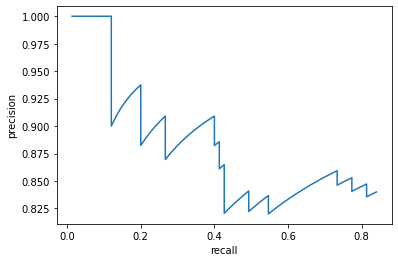

In [ ]:
print(precision)
print(recall)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
print("Mean of precision is {}".format(np.mean(np.array(precision))))
print("Mean of recall is {}".format(np.mean(np.array(recall))))